<a href="https://colab.research.google.com/github/Sayak-kgl/Railofy/blob/main/railofy-rf-xgb-tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Authentication

In [ ]:
# Access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Make directory
!mkdir ~/.kaggle

# Copy the kaggle.json API token to above directory
!cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/kaggle.json

# Change permissions
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
#Downloading competition data
!kaggle competitions download -c railofy-challenge

# Extracting datasets
!unzip railofy-challenge.zip

  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 257MB/s]
Archive:  railofy-challenge.zip
  inflating: Railofy_testing_data_for_model.csv  
  inflating: Railofy_training_data_for_model.csv  
  inflating: sample_submission.csv   


# **Importing Libraries**

In [4]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV 
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# **Loading Datasets**

## Train

In [5]:
train_df = pd.read_csv("Railofy_training_data_for_model.csv")
print(train_df.shape)
train_df.head()

(36775, 25)


,pk,QT,GRCA,CCA,JD,ODD,JS,ODS,SL,NDTD,...,GRA,CURA,RPW,CUCA,CAR,BKT_2,CL_1,CL_2,CL_3,target
0,88315053602,GN,1.400436,0.610522,0.667146,0.930870,0.709433,0.800000,1,0.016290,...,1.341754,1.820791,0.280196,-0.007556,1.091054,0,0,1,0,0
1,88315053603,GN,1.400436,0.610522,0.667146,0.930870,0.709433,0.800000,1,0.024623,...,1.999409,3.810137,0.276128,-0.007556,1.143376,0,0,1,0,0
2,88314793081,GN,0.728882,0.524062,1.365898,0.885873,1.463205,0.767442,0,0.004357,...,0.618700,0.742814,0.278101,0.435419,5.000000,0,0,0,0,0
3,88312760631,GN,5.000000,5.000000,0.298977,0.764192,0.354716,0.800000,0,0.003798,...,1.117669,1.079367,0.266220,0.091167,5.000000,1,0,0,0,1
4,88312449843,GN,0.614226,0.389327,0.699606,0.917133,1.108489,0.862069,1,0.024571,...,4.393867,5.000000,0.277710,2.103696,1.454895,1,0,1,0,0


## Test

In [6]:
test_df = pd.read_csv("Railofy_testing_data_for_model.csv")
print(test_df.shape)
test_df.head()

(3847, 24)


,pk,QT,GRCA,CCA,JD,ODD,JS,ODS,SL,NDTD,...,SCRA,GRA,CURA,RPW,CUCA,CAR,BKT_2,CL_1,CL_2,CL_3
0,8831606085,GN,0.065517,0.041589,1.614476,1.000000,1.773582,0.975610,1,0.008326,...,0.058562,0.705277,1.457012,0.280196,1.335478,1.692308,0,0,0,1
1,8831561565,GN,2.710786,1.658815,0.927683,0.836028,0.665093,0.681818,1,0.013590,...,0.119819,-0.323278,-0.195543,0.276128,-0.537617,1.629686,0,1,0,0
2,8831539811,GN,3.365960,1.514607,1.546139,0.961232,1.418866,0.888889,1,0.008322,...,0.200964,0.305956,0.328951,0.276128,-0.093347,1.116554,0,1,0,0
3,8831313791,GN,2.342250,1.277346,0.990041,1.000000,0.842451,0.950000,1,0.007728,...,1.082519,0.446952,0.494185,0.271758,0.069792,1.442885,0,1,0,0
4,8831070109,GN,0.139225,0.054502,1.575182,0.817376,2.571694,0.773333,1,0.024999,...,1.975081,3.847262,3.497138,0.267730,1.296174,1.372434,0,0,1,0


# **Data Description**

Dataset description is not given by host. In order to understand the data better, I looked up the variables and tried to understand how the features are related to railway. I was unable to find detailed descroption of all the features. For those I could find, the links to avail the information has been attached. Data descriptions I am not least confident of have been marked with a '?' mark.


**pk** - Primary key, also PNR number (https://paytm.com/train-tickets/pnr-status)<br>
**QT** - Quota (GN: general quota, PQ: pooled quota, RL: remote location quota) (https://www.indianrail.gov.in/enquiry/StaticPages/StaticEnquiry.jsp?StaticPage=quota_Code.html&locale=en)<br>
**ODS** -Optimization of the origin and destination of trains (https://www.researchgate.net/publication/252033209_Research_on_optimization_of_train_ODs_scheme_for_high-speed_railways)<br>
**SL** - Sleeper class coach<br>
**NDTD** - Downward nose - downward tail of a Hyperloop pod. (https://www.researchgate.net/publication/357856710_Numerical_study_on_the_influence_of_the_nose_and_tail_shape_on_the_aerodynamic_characteristics_of_a_Hyperloop_pod)<br>
**SCRA** - Special Class Railway Apprentice?<br>
**GRA** - General Risk Assessment?<br>
**RPW** - Railway Parcel Way Bill?<br>

# **Cleaning**

## Train

In [7]:
print(train_df.info())
train_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36775 entries, 0 to 36774
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pk      36775 non-null  int64  
 1   QT      36775 non-null  object 
 2   GRCA    36775 non-null  float64
 3   CCA     36775 non-null  float64
 4   JD      36775 non-null  float64
 5   ODD     36775 non-null  float64
 6   JS      36775 non-null  float64
 7   ODS     36775 non-null  float64
 8   SL      36775 non-null  int64  
 9   NDTD    36775 non-null  float64
 10  CURP    36775 non-null  float64
 11  GROP    36775 non-null  float64
 12  CANP    36775 non-null  float64
 13  SBRA    36775 non-null  float64
 14  SCRA    36775 non-null  float64
 15  GRA     36775 non-null  float64
 16  CURA    36775 non-null  float64
 17  RPW     36775 non-null  float64
 18  CUCA    36775 non-null  float64
 19  CAR     36775 non-null  float64
 20  BKT_2   36775 non-null  int64  
 21  CL_1    36775 non-null  int64  
 22

pk        0
QT        0
GRCA      0
CCA       0
JD        0
ODD       0
JS        0
ODS       0
SL        0
NDTD      0
CURP      0
GROP      0
CANP      0
SBRA      0
SCRA      0
GRA       0
CURA      0
RPW       0
CUCA      0
CAR       0
BKT_2     0
CL_1      0
CL_2      0
CL_3      0
target    0
dtype: int64

No null values present.

In [8]:
train_df.loc[train_df.duplicated(['pk']),:]

,pk,QT,GRCA,CCA,JD,ODD,JS,ODS,SL,NDTD,...,GRA,CURA,RPW,CUCA,CAR,BKT_2,CL_1,CL_2,CL_3,target
27518,61017898402,RL,0.507760,1.393839,0.784174,0.769489,0.798112,0.486486,1,0.001846,...,0.548753,0.517636,0.247461,-0.164658,3.887704,1,1,0,0,0
27519,61017898403,GN,2.678027,1.393839,0.830302,0.814753,0.975470,0.594595,1,0.014351,...,1.189930,1.081251,0.244202,-0.164658,0.911847,1,1,0,0,0
36328,22406560832,RL,0.884486,1.243159,0.662021,0.632137,0.532075,0.631579,1,0.005524,...,2.573901,1.458280,0.243260,0.395827,1.074775,1,1,0,0,1


3 primary keys seem to have duplicates.

In [9]:
train_df.drop_duplicates("pk", keep = "first", inplace = True)

## Test

In [10]:
print(test_df.info())
test_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847 entries, 0 to 3846
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pk      3847 non-null   int64  
 1   QT      3847 non-null   object 
 2   GRCA    3847 non-null   float64
 3   CCA     3847 non-null   float64
 4   JD      3847 non-null   float64
 5   ODD     3847 non-null   float64
 6   JS      3847 non-null   float64
 7   ODS     3847 non-null   float64
 8   SL      3847 non-null   int64  
 9   NDTD    3847 non-null   float64
 10  CURP    3847 non-null   float64
 11  GROP    3847 non-null   float64
 12  CANP    3847 non-null   float64
 13  SBRA    3847 non-null   float64
 14  SCRA    3847 non-null   float64
 15  GRA     3847 non-null   float64
 16  CURA    3847 non-null   float64
 17  RPW     3847 non-null   float64
 18  CUCA    3847 non-null   float64
 19  CAR     3847 non-null   float64
 20  BKT_2   3847 non-null   int64  
 21  CL_1    3847 non-null   int64  
 22  

pk       0
QT       0
GRCA     0
CCA      0
JD       0
ODD      0
JS       0
ODS      0
SL       0
NDTD     0
CURP     0
GROP     0
CANP     0
SBRA     0
SCRA     0
GRA      0
CURA     0
RPW      0
CUCA     0
CAR      0
BKT_2    0
CL_1     0
CL_2     0
CL_3     0
dtype: int64

No null values present

In [11]:
test_df.loc[train_df.duplicated(['pk']),:]

,pk,QT,GRCA,CCA,JD,ODD,JS,ODS,SL,NDTD,...,SCRA,GRA,CURA,RPW,CUCA,CAR,BKT_2,CL_1,CL_2,CL_3


No duplicates detected.

# **Feature Engineering**

## Feature Distribution

### Extracting zones from PNR (primary key - pk)

According to this source https://paytm.com/train-tickets/pnr-status, the first 3 digits of the PNR indicate the Passenger Reservation System. The first digit of the PNR indicate the zone of the departure station of the train.

In [12]:
train_df['PRS'] = train_df['pk'].astype('str').str[:1].astype(np.int64)
train_df=train_df.drop(['pk'],axis=1)
train_df['PRS']=train_df['PRS'].replace({
    1:'Secunderabad',
    2:'New_Delhi',
    3:'New_Delhi',
    4:'Chennai',
    5:'Chennai',
    6:'Kolkata',
    7:'Kolkata',
    8:'Mumbai',
    9:'Mumbai'
})


test_df['PRS'] = test_df['pk'].astype('str').str[:1].astype(np.int64)
test_df=test_df.drop(['pk'],axis=1)
test_df['PRS']=test_df['PRS'].replace({
    1:'Secunderabad',
    2:'New_Delhi',
    3:'New_Delhi',
    4:'Chennai',
    5:'Chennai',
    6:'Kolkata',
    7:'Kolkata',
    8:'Mumbai',
    9:'Mumbai'
})

### Checking frequency distributions of categorical and numerical variables

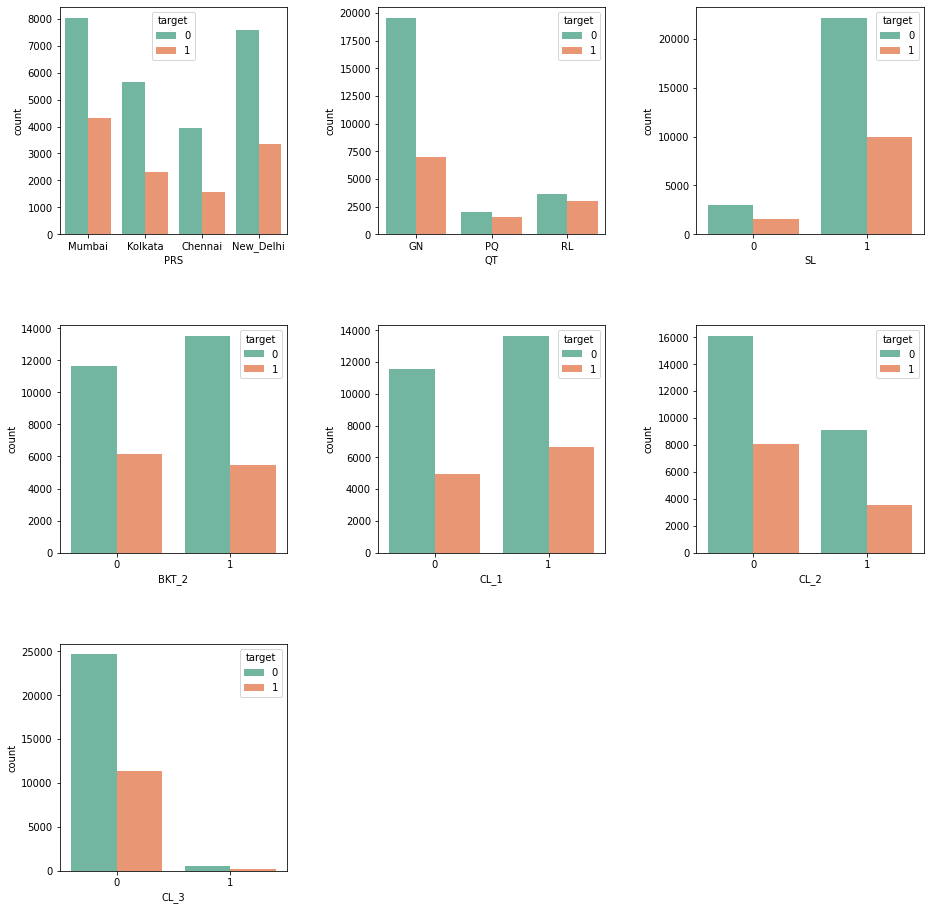

In [13]:
cat = ['PRS','QT','SL','BKT_2','CL_1','CL_2','CL_3']
plt.figure(figsize=(15,15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
i = 1
for c in cat:
    plt.subplot(3,3,i)
    sns.countplot(x=c,hue="target",data=train_df, palette= 'Set2')
    i+=1

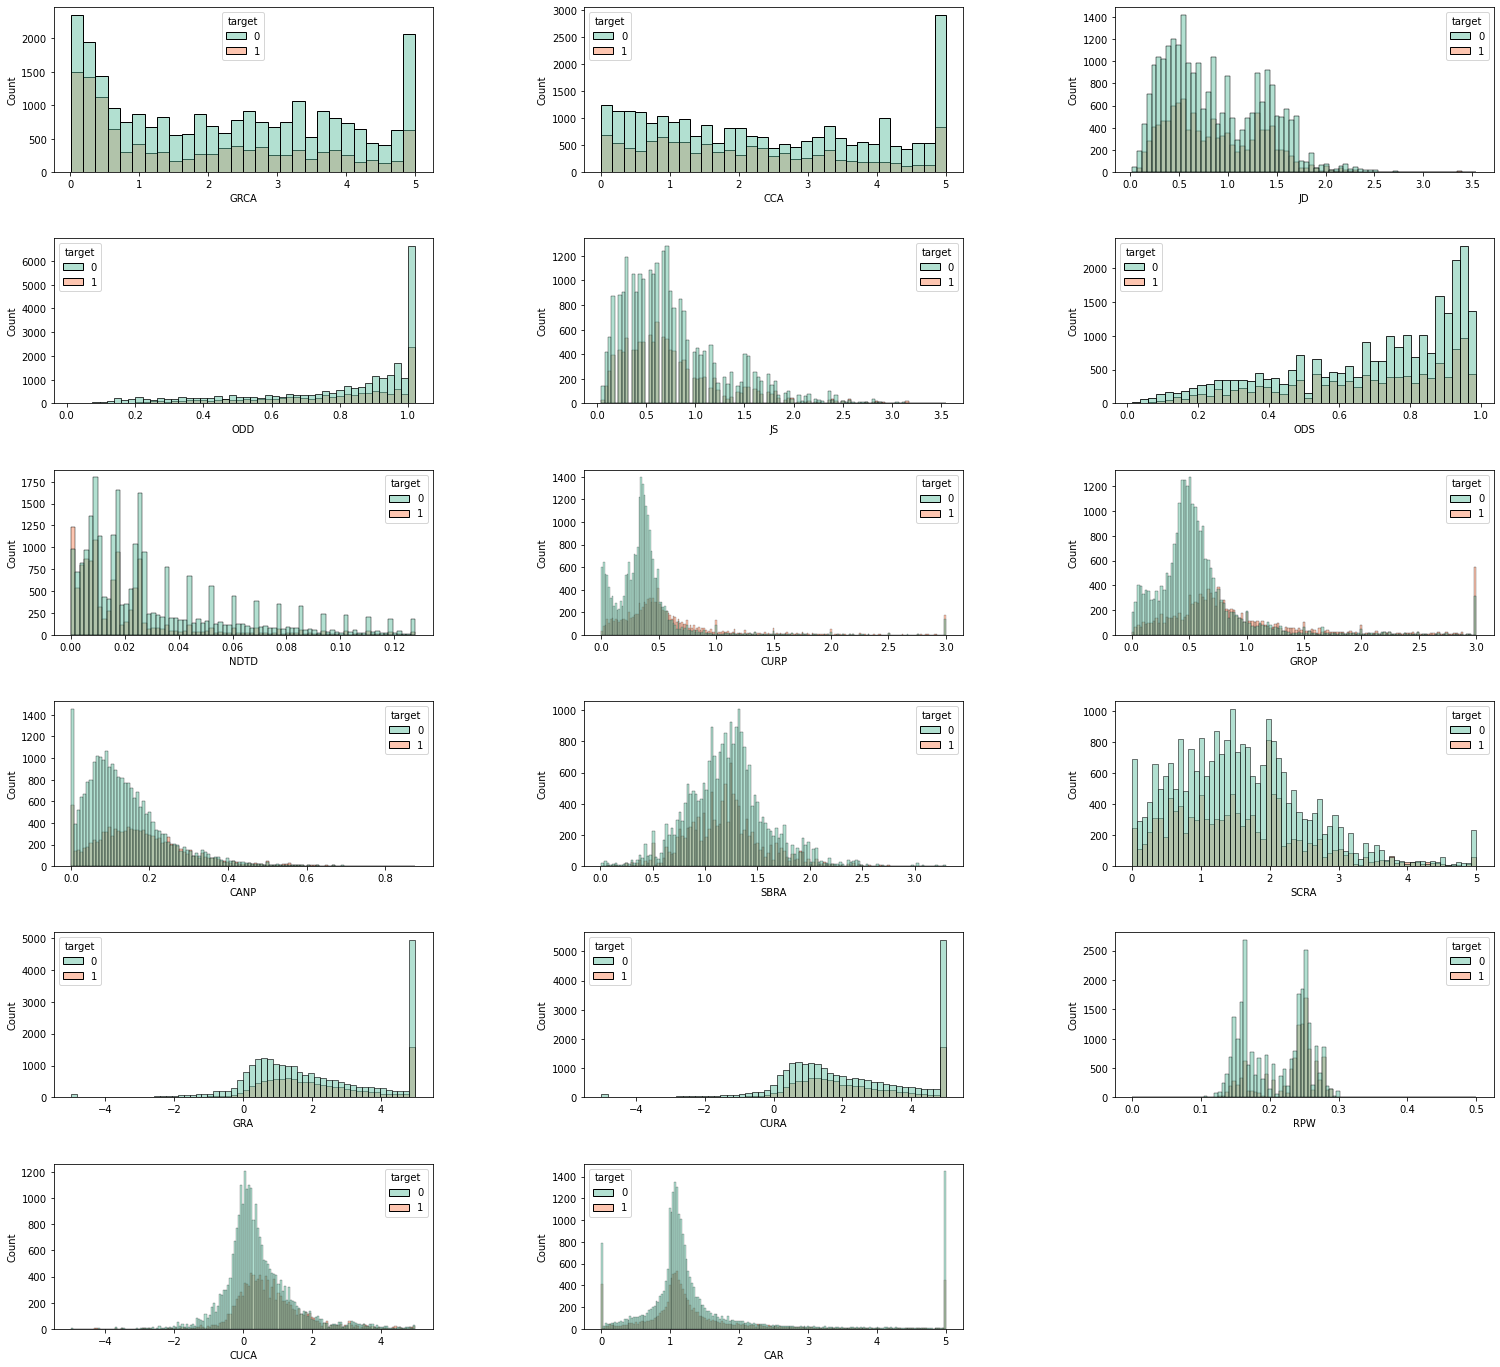

In [14]:
num = ['GRCA', 'CCA', 'JD', 'ODD', 'JS', 'ODS', 'NDTD', 'CURP', 'GROP', 'CANP', 'SBRA', 'SCRA', 'GRA', 'CURA', 'RPW', 'CUCA', 'CAR']


plt.figure(figsize=(25,35))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
j = 1
for c in num:
    plt.subplot(9,3,j)
    sns.histplot(x=c,hue="target", data=train_df, palette= 'Set2')
    j+=1

### Encoding categorical attributes

In [15]:
train_df = pd.concat([train_df, pd.get_dummies(train_df[['QT', 'PRS']])], axis = 1)
train_df = train_df.drop(['QT', 'PRS'], axis=1)
train_df.head()

,GRCA,CCA,JD,ODD,JS,ODS,SL,NDTD,CURP,GROP,...,CL_2,CL_3,target,QT_GN,QT_PQ,QT_RL,PRS_Chennai,PRS_Kolkata,PRS_Mumbai,PRS_New_Delhi
0,1.400436,0.610522,0.667146,0.930870,0.709433,0.800000,1,0.016290,0.204678,0.409357,...,1,0,0,1,0,0,0,0,1,0
1,1.400436,0.610522,0.667146,0.930870,0.709433,0.800000,1,0.024623,0.216374,0.409357,...,1,0,0,1,0,0,0,0,1,0
2,0.728882,0.524062,1.365898,0.885873,1.463205,0.767442,0,0.004357,0.089888,0.101124,...,0,0,0,1,0,0,0,0,1,0
3,5.000000,5.000000,0.298977,0.764192,0.354716,0.800000,0,0.003798,0.314147,0.328710,...,0,0,1,1,0,0,0,0,1,0
4,0.614226,0.389327,0.699606,0.917133,1.108489,0.862069,1,0.024571,0.253333,0.560000,...,1,0,0,1,0,0,0,0,1,0


In [16]:
test_df = pd.concat([test_df, pd.get_dummies(test_df[['QT', 'PRS']])], axis = 1)
test_df = test_df.drop(['QT', 'PRS'], axis=1)
test_df.head()

,GRCA,CCA,JD,ODD,JS,ODS,SL,NDTD,CURP,GROP,...,CL_1,CL_2,CL_3,QT_GN,QT_PQ,QT_RL,PRS_Chennai,PRS_Kolkata,PRS_Mumbai,PRS_New_Delhi
0,0.065517,0.041589,1.614476,1.000000,1.773582,0.975610,1,0.008326,0.375000,0.625000,...,0,0,1,1,0,0,0,0,1,0
1,2.710786,1.658815,0.927683,0.836028,0.665093,0.681818,1,0.013590,0.299094,0.368580,...,1,0,0,1,0,0,0,0,1,0
2,3.365960,1.514607,1.546139,0.961232,1.418866,0.888889,1,0.008322,0.493917,0.688564,...,1,0,0,1,0,0,0,0,1,0
3,2.342250,1.277346,0.990041,1.000000,0.842451,0.950000,1,0.007728,0.440559,0.695804,...,1,0,0,1,0,0,0,0,1,0
4,0.139225,0.054502,1.575182,0.817376,2.571694,0.773333,1,0.024999,0.411765,1.176471,...,0,1,0,1,0,0,0,0,1,0


# **Building Prediction Model**

## Train Test Split

In [17]:
X = train_df.drop(['target'], axis=1)
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

X_test = test_df.copy()
print(X_test.shape)

(27579, 29) (9193, 29) (27579,) (9193,)
(3847, 29)


## Feature Scaling

In [18]:
scaler = preprocessing.RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [19]:
X_test = scaler.transform(X_test)

## Classification Models

### Baseline

Defining functions to print accuracy scores, confusion matrices and classification reports.

In [20]:
def model_accuracy(clf_object, val_x, val_y):
    score = clf_object.score(val_x, val_y)
    print(f'Accuracy is {round(score*100,2)}%')
    
def clf_report(model_name, val_y, pred_y):
    print(f'{model_name} Classification Report: \n ------------------------------------------')
    print()
    print(classification_report(val_y, pred_y, target_names=['0', '1']))

#### *Logistic Regression*

In [ ]:
# lr = LogisticRegression(max_iter = 7500)
# lr.fit(X_train, y_train)

# model_accuracy(lr, X_val, y_val)

#### *SVM*

In [ ]:
# svc = SVC(probability = True)
# svc.fit(X_train, y_train)

# model_accuracy(svc, X_val, y_val)

#### *Random Forest*

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

model_accuracy(rf, X_val, y_val)

Accuracy is 92.06%


#### *XGBoost*

In [22]:
xgb = XGBClassifier(random_state =1)
xgb.fit(X_train, y_train)

model_accuracy(xgb, X_val, y_val)

Accuracy is 80.65%


### Hyper-parameter tuning

Defining a function to print best parameters and score

In [23]:
def model_performance(clf_object, model_name, val_x, val_y):
    print(model_name)
    print(f'Best Score: {clf_object.best_estimator_.score(val_x, val_y)}')
    print(f'Best Parameters: {clf_object.best_params_}')

#### *Logistic Regression*

In [ ]:
# # Grid search to find best paramters

# lr = LogisticRegression()
# param_grid = {
#     'penalty' : ['l1', 'l2', 'elasticnet'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [7500,10000]
# }

# lr_grid = GridSearchCV(lr, param_grid = param_grid, cv = 4, verbose = True, n_jobs = -1)
# lr_grid.fit(X_train,y_train)

# model_performance(lr_grid,'Logistic Regression', X_val, y_val)

In [ ]:
# y_pred_proba = lr_grid.best_estimator_.predict_proba(X_val)
# log_loss = log_loss(y_val, y_pred_proba)
# print("Log Loss:", log_loss)

#### *SVM*

In [ ]:
# # Grid search to find best paramters

# svc = SVC(probability = True)
# param_grid = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
#                                   'C': [.1, 1, 10, 100, 1000]},
#                                  {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
#                                  {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
# svc_grid = GridSearchCV(svc, param_grid = param_grid, cv = 4, verbose = True, n_jobs = -1)
# svc_grid.fit(X_train,y_train)

# model_performance(svc_grid,'SVM', X_val, y_val)

In [ ]:
# y_pred = svc_grid.best_estimator_.predict(X_val)
# clf_report('Tuned SVM', y_val, y_pred)

#### *Random Forest*

In [ ]:
# # Randomized search to narrow down the paramters


# param_grid =  {
#     'n_estimators': [100,300,600,900,1200,1400,1600,1800],
#     'criterion' : ['gini', 'entropy'],
#     'bootstrap': [True,False],
#     'max_depth': [4,10,14,18,20,24,28,30,34,38,40,None]
#     'max_features': ['auto','sqrt',10],
#     'min_samples_leaf': [1,2,3],
#     'min_samples_split': [2,3,4]
# }
                                  
# rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
# rf_rnd.fit(X_train,y_train)
# model_performance(rf_rnd,'Random Forest', X_val, y_val)

In [ ]:
# # Grid search to find best paramters

# param_grid =  {
#     'criterion' : ['entropy'],
#     'n_estimators': [1558], 
#     'bootstrap': [True],
#     'max_depth': [34],
#     'max_features': ['sqrt'],
#     'min_samples_leaf': [1],
#     'min_samples_split': [2],
    
# }
                                  
# rf_grid = GridSearchCV(rf, param_grid = param_grid, cv = 4, verbose = 2, n_jobs = -1)
# rf_grid.fit(X_train,y_train)

# model_performance(rf_grid,'Random Forest', X_val, y_val)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Random Forest
Best Score: 0.9246165560752747
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 34, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1558}


In [ ]:
# y_pred = rf_grid.best_estimator_.predict(X_val)
# clf_report('Tuned Random Forest', y_val, y_pred)

Tuned Random Forest Classification Report: 
 ------------------------------------------

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      6314
           1       0.93      0.82      0.87      2879

    accuracy                           0.92      9193
   macro avg       0.93      0.90      0.91      9193
weighted avg       0.92      0.92      0.92      9193



#### *XGBoost*

In [ ]:
# # Randomized search to narrow down the paramters

# xgb = XGBClassifier(random_state = 1)

# param_grid = {
#     'n_estimators': [20, 50, 100, 250, 500,1000],
#     'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
#     'max_depth': [2, 5, 10, 15, 20, 25, None],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [1, 1.5, 2],
#     'subsample': [0.5,0.6,0.7, 0.8, 0.9],
#     'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
#     'gamma':[0,.01,.1,1,10,100],
#     'min_child_weight':[0,.01,0.1,1,10,100],
#     'sampling_method': ['uniform', 'gradient_based']
# }

# xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 100, cv = 4, verbose = 2, n_jobs = -1)
# xgb_rnd.fit(X_train,y_train)

# model_performance(xgb_rnd,'XGBoost', X_val, y_val)

In [ ]:
# # Grid search to find best paramters

# xgb = XGBClassifier(random_state = 1)

# param_grid = {
#     'n_estimators': [1000, 1300, 1600, 1800],
#     'colsample_bytree': [0.8, 1],
#     'max_depth': [25, 30, 35],
#     'reg_alpha': [0],
#     'reg_lambda': [2],
#     'subsample': [0.9],
#     'learning_rate':[0.7, 0.8],
#     'gamma':[0],
#     'min_child_weight':[0.1],
#     'sampling_method': ['uniform', 'gradient_based']
# }

# xgb_grid = GridSearchCV(xgb, param_grid = param_grid, cv = 4, verbose = 2, n_jobs = -1)
# xgb_grid.fit(X_train,y_train)

# model_performance(xgb_grid,'XGBoost', X_val, y_val)

In [24]:
# Grid search to find best paramters

xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [1600],
    'colsample_bytree': [0.8],
    'max_depth': [30],
    'reg_alpha': [0],
    'reg_lambda': [2],
    'subsample': [0.9],
    'learning_rate':[0.8],
    'gamma':[0],
    'min_child_weight':[0.1],
    'sampling_method': ['uniform']
}

xgb_grid = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = 2, n_jobs = -1)
xgb_grid.fit(X_train,y_train)

model_performance(xgb_grid,'XGBoost', X_val, y_val)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
XGBoost
Best Score: 0.9345153921461982
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.8, 'max_depth': 30, 'min_child_weight': 0.1, 'n_estimators': 1600, 'reg_alpha': 0, 'reg_lambda': 2, 'sampling_method': 'uniform', 'subsample': 0.9}


In [25]:
y_pred = xgb_grid.best_estimator_.predict(X_val)
clf_report('Tuned XGBoost', y_val, y_pred)

Tuned XGBoost Classification Report: 
 ------------------------------------------

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6314
           1       0.92      0.87      0.89      2879

    accuracy                           0.93      9193
   macro avg       0.93      0.92      0.92      9193
weighted avg       0.93      0.93      0.93      9193



# **Submission**

In [32]:
final_pred_proba = xgb_grid.best_estimator_.predict_proba(X_test)

final_df = pd.DataFrame()
final_df['pk'] = pd.read_csv("Railofy_testing_data_for_model.csv")['pk']

In [33]:
final_df['target'] = final_pred_proba[:,1]
final_df.head()

,pk,target
0,8831606085,0.017421
1,8831561565,0.000051
2,8831539811,0.848222
3,8831313791,0.020525
4,8831070109,0.014954


In [34]:
final_df.to_csv("submission.csv", index=False)

In [37]:
!kaggle competitions submit -c  railofy-challenge -m "xgb model auc" -f "submission.csv"

100% 86.8k/86.8k [00:00<00:00, 216kB/s]
Successfully submitted to Indian Railways Challenge